In [1]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
# import seaborn as sns
# sns.set_style("white")

%matplotlib inline

import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook #, tnrange

#from itertools import chain
# from skimage.io import imread, imshow #, concatenate_images
# from skimage.transform import resize
# from skimage.morphology import label

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import models
import torch.utils.model_zoo as model_zoo

import time
t_start = time.time()

# print("Program started at:", t_start)
print(os.listdir())

['sample_submission.csv', 'uresnetv6e1statef1bl.pt', 'ff kNN.ipynb', 'uresnetv6e18statef1bl.pt', 'EDA and LSTM tf.ipynb', 'uresnetv6e53statef1.pt', 'unet_resnet_pytorch_v4.ipynb', 'uresnetv6e35statef1.pt', 'uresnetv6e46statef1.pt', 'uresnetv6e49statef1.pt', 'unet_resnet_pytorch.ipynb', 'uresnetv6e47statef1.pt', 'uresnetv6e33statef1.pt', 'train', 'uresnetv6e6statef1bl.pt', 'uresnetv6e11statef1.pt', 'uresnetv6e44statef1.pt', 'uresnetv6e13statef1bl.pt', 'uresnetv6e8statef1bl.pt', 'uresnetv6e2statef1.pt', 'depths.csv', 'uresnetv6e50statef1.pt', 'uresnetv6e54statef1.pt', 'uresnetv6e43statef1.pt', 'uresnetv6e5statef1bl.pt', 'uresnetv6e24statef1.pt', 'uresnetv6e30statef1.pt', 'uresnetv6e3statef1.pt', 'uresnetv6e3statef1bl.pt', 'uresnetv6e29statef1.pt', 'uresnetv6e1statef1.pt', 'uresnetv6e16statef1.pt', 'uresnetv6e41statef1.pt', 'uresnetv6e26statef1.pt', 'uresnetv6e18statef1.pt', 'uresnetv6e9statef1bl.pt', '.ipynb_checkpoints', 'uresnetv6e55statef1.pt', 'uresnetv6e36statef1.pt', 'uresnetv6e5st

# Parameters:

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)
data_src = ''

quick_try = False
grayscale = True

orig_image_size = (101, 101)
image_size = (128, 128)

Device: cuda:0


In [3]:

# Resnet34 encoder from https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}

# A same convolution conv3x3 layer
def conv3x3(inplanes, planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

    
def conv1x1(in_channels, out_channels, groups=1):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=1,
        groups=groups,
        stride=1)

class CSE(nn.Module):
    def __init__(self, in_ch, r):
        super(CSE, self).__init__()

        self.linear_1 = nn.Linear(in_ch, in_ch//r)
        self.linear_2 = nn.Linear(in_ch//r, in_ch)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        input_x = x

        x = x.view(*(x.shape[:-2]),-1).mean(-1)
        x = F.relu(self.linear_1(x), inplace=True)
        x = self.linear_2(x)
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = self.sigmoid(x)

        x = input_x * x

        return x

class SSE(nn.Module):
    def __init__(self, in_ch):
        super(SSE, self).__init__()

        self.conv = nn.Conv2d(in_ch, 1, kernel_size=1, stride=1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        input_x = x

        x = self.conv(x)
        x = self.sigmoid(x)

        x = input_x * x

        return x
    
class SCSE(nn.Module):
    def __init__(self, in_ch, r):
        super(SCSE, self).__init__()

        self.cSE = CSE(in_ch, r)
        self.sSE = SSE(in_ch)

    def forward(self, x):
        cSE = self.cSE(x)
        sSE = self.sSE(x)

        x = cSE + sSE

        return x

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out    

# One residual block (for encoding layers)
# Downsamples at the beginning if necessary
class uBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, firstlayer=False):
        super(BasicBlock, self).__init__()
        self.downsample = downsample
        self.inplanes = inplanes
        self.firstlayer = firstlayer
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # WHY ARE WE USING 3x3 WINDOW? OH WELL
        self.conv1 = conv3x3(inplanes, planes, stride)    
        self.bn2 = nn.BatchNorm2d(planes)  
        self.conv2 = conv3x3(planes, planes)              
        self.stride = stride

    def forward(self, x):
        residual = x
        # print(x.size())
        x = self.bn1(x)
        x = self.relu(x)
        if self.firstlayer == True: # This is probably not the best way to do this... fix in the future
            x = self.maxpool(x)
            x = self.conv2(x)
            residual = self.conv1(x)
        else:
            x = self.conv1(x)            
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2(x)
        # print(x.size())
        # print(residual.size())
        
        if self.downsample is not None:
            residual = self.downsample(residual)
        
        x += residual
        
        return x

# Decoder block containing 2D transposed Convolution upsampling the features
class DecoderBlock(nn.Module):
    def __init__(self, inplanes, planes, outplanes, stride=1):
        super().__init__()
        
        self.block = nn.Sequential(
            conv3x3(inplanes, planes, stride),
            nn.BatchNorm2d(planes),
            nn.ReLU(inplace=True),
            conv3x3(planes, outplanes, stride),
            nn.BatchNorm2d(outplanes),
            nn.ReLU(inplace=True),
            SCSE(outplanes, 2),
            
        )

    def forward(self, x, e=None):
        x = F.upsample(x, scale_factor=2, mode='bilinear', align_corners=True)
        if e is not None:
            x = torch.cat([x,e], 1)
        return self.block(x)    


# Need this separate class to load weights into? We'll see
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

        
# WIP
class UResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        super(UResNet, self).__init__()
        self.resnet = resnet34(pretrained=True)
        self.conv1 = nn.Sequential(self.resnet.conv1,
                                  self.resnet.bn1,
                                  self.resnet.relu)
        self.inplanes = 64
        
        # Encoding layers
        self.layer1 = self.resnet.layer1
        self.layer2 = self.resnet.layer2
        self.layer3 = self.resnet.layer3
        self.layer4 = self.resnet.layer4
        
        # self.avgpool = nn.AvgPool2d(7, stride=1)  # I don't think we need this in the U-net bottleneck layer
        # self.fc = nn.Linear(512 * block.expansion, num_classes) # I don't think we need this in the U-net bottleneck layer
        
        # Center layer
        self.center = nn.Sequential(#nn.BatchNorm2d(512),
                                    #nn.ReLU(inplace=True),
                                    nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
                                    nn.BatchNorm2d(512),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(512, 256, kernel_size=3, padding=1, stride=1),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU(inplace=True),
                                    nn.MaxPool2d(kernel_size=2, stride=2)
                                   )
        
        # Decoding layers with cat
       
        self.layer4e = DecoderBlock(256 + 512, 512, 64)
        self.layer3e = DecoderBlock(64 + 256, 256, 64)
        self.layer2e = DecoderBlock(64 + 128, 128, 64)
        self.layer1e = DecoderBlock(64 + 64, 64, 64)
        self.layer0e = DecoderBlock(64, 32, 64) # This one no cat actually
        # Decoding layers without cat
        
        self.logit = nn.Sequential(conv3x3(320,64,1),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(64, 1, kernel_size=1, padding=0),
                                  # nn.Sigmoid() # Lovasz-hinge needs logit output, not sigmoid
                                  )
        
        self.relu = nn.ReLU(inplace=True)
        
        self.dropout2d = nn.Dropout2d()
        

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_encoding_layer(self, block, planes, blocks, stride=1, firstlayer=False):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion) # Is this batch norm necessary?,
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, firstlayer=firstlayer))
        self.inplanes = planes * block.expansion
        
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
       
    def forward(self, x):
        # Pre-res layers
        
        x = self.conv1(x) # 128x128x1 -> 128x128x64
        
        # Encoding layers
        conv2 = self.layer1(x) # 128x128x64 -> 64x64x64        
        conv3 = self.layer2(conv2) # output: 32x32x128
        conv4 = self.layer3(conv3) # output: 16x16x256
        conv5 = self.layer4(conv4) # output: 8x8x512
        f = self.center(conv5) #output: 4x4x256
        
        # Decoding layers
        conv4e = self.layer4e(f, conv5) # output: 8x8x64
        conv3e = self.layer3e(conv4e, conv4) # output: 16x16x64
        conv2e = self.layer2e(conv3e, conv3) # output: 32x32x64
        conv1e = self.layer1e(conv2e, conv2) # output: 64x64x64
        conv0e = self.layer0e(conv1e) # output: 128x128x64
        
        # Hypercolumns
        f = torch.cat([conv0e,
                     F.interpolate(conv1e, scale_factor=2, mode='bilinear', align_corners=False),
                     F.interpolate(conv2e, scale_factor=4, mode='bilinear', align_corners=False),
                     F.interpolate(conv3e, scale_factor=8, mode='bilinear', align_corners=False),
                     F.interpolate(conv4e, scale_factor=16, mode='bilinear', align_corners=False)], 1)
        # f = self.dropout2d(f)
        
        y = self.logit(f)

        
        return y

def resnet34(pretrained=False, **kwargs):
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    model.train()
    return model

def Uresnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = UResNet(uBasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    model.train()
    return model.to(device)
    
model = Uresnet34()
print("Network architecture created.")

Network architecture created.


__Code for performing augmentations__:

In [4]:
import imgaug as ia
from imgaug import augmenters as iaa
import cv2
def do_augmentation(seqs, seq2_train, X_train, y_train):
    # Use seq_det to build augmentation.

    seq_det = seqs.to_deterministic()
    X_train_aug = seq_det.augment_image(X_train)
    X_train_aug = seq2_train.augment_image(X_train_aug)

    y_train_aug = seq_det.augment_image(y_train)



    if y_train_aug.shape != (101, 101):
        X_train_aug = ia.imresize_single_image(X_train_aug, (101, 101), interpolation="linear")
        y_train_aug = ia.imresize_single_image(y_train_aug, (101, 101), interpolation="nearest")


    return np.array(X_train_aug), np.array(y_train_aug)


# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # horizontally flip

    iaa.OneOf([
        iaa.Noop(),
        iaa.Affine(rotate=(-10, 10), translate_percent={"x": (-0.25, 0.25)}, mode='symmetric', cval=(0), backend="cv2"),
        iaa.Noop(),
        iaa.CropAndPad(
            percent=(-0.2, 0.2),
            pad_mode="reflect",
            pad_cval=0,
            keep_size=False
        ),
        # aa.Noop(),
        # aa.PiecewiseAffine(scale=(0.01, 0.1), mode='edge', cval=(0)),
    ])

    # More as you want ...
])
seq_train = iaa.Sequential(
    sometimes(iaa.Multiply((0.8, 1.2))),  # , per_channel=0.5
    sometimes(iaa.Add((-0.2, 0.2))),  # , per_channel=0.5
    sometimes(iaa.OneOf([
        iaa.AdditiveGaussianNoise(scale=(0, 0.05)),
        iaa.GaussianBlur(sigma=(0.0, 1.0)),
    ]))

)

In [5]:
class TGSSaltDataset(data.Dataset):

    def __init__(self,
                 root_path,
                 file_list,
                 is_test=False,
                 divide=False,
                 reflect=False,
                 image_size=(128, 128)):

        self.root_path = root_path
        self.file_list = file_list
        self.is_test = is_test

        self.divide = divide
        self.reflect= reflect
        self.image_size = image_size

        self.orig_image_size = (101, 101)
        self.padding_pixels = None
        
        """
        root_path: folder specifying files location
        file_list: list of images IDs
        is_test: whether train or test data is used (contains masks or not)
        
        divide: whether to divide by 255
        image_size: output image size, should be divisible by 32
        
        orig_image_size: original images size
        padding_pixels: placeholder for list of padding dimensions
        """

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        if index not in range(0, len(self.file_list)):
            return self.__getitem__(np.random.randint(0, self.__len__()))

        file_id = self.file_list[index]

        # Get image path
        image_folder = os.path.join(self.root_path, 'images')
        image_path = os.path.join(image_folder, file_id + '.png')
    
        # Get mask path
        mask_folder = os.path.join(self.root_path, 'masks')
        mask_path = os.path.join(mask_folder, file_id + '.png')

        # Load image
        image = self.__load_image(image_path)
        if not self.is_test:
            # Load mask for training or evaluation
            mask = self.__load_image(mask_path, mask=True)
            if self.divide:
                image = image / 255.
                mask = mask / 255.
            # Transform into torch float Tensors of shape (CxHxW).
            image = torch.from_numpy(
                np.expand_dims(image, axis=-1)).float().permute([2, 0, 1])            
            image = self.__add_depth_channels(image)
            mask = torch.from_numpy(
                np.expand_dims(mask, axis=-1)).float().permute([2, 0, 1])
            return image, mask

        if self.is_test:
            if self.divide:
                image = image / 255.
            image = torch.from_numpy(np.expand_dims(image, axis=-1)).float().permute([2, 0, 1])
            image = self.__add_depth_channels(image)
            return (image,)

    def set_padding(self):

        """
        Compute padding borders for images based on original and specified image size.
        """
        
        pad_floor = np.floor(
            (np.asarray(self.image_size) - np.asarray(self.orig_image_size)) / 2)
        pad_ceil = np.ceil((np.asarray(self.image_size) -
                            np.asarray(self.orig_image_size)) / 2)

        self.padding_pixels = np.asarray(
            (pad_floor[0], pad_ceil[0], pad_floor[1], pad_ceil[1])).astype(np.int32)

        return

    def __pad_image(self, img):
        
        """
        Pad images according to border set in set_padding.
        Original image is centered.
        """

        y_min_pad, y_max_pad, x_min_pad, x_max_pad = self.padding_pixels[
            0], self.padding_pixels[1], self.padding_pixels[2], self.padding_pixels[3]

        img = cv2.copyMakeBorder(img, y_min_pad, y_max_pad,
                                 x_min_pad, x_max_pad,
                                 cv2.BORDER_REFLECT)

        assert img.shape[:2] == self.image_size, '\
        Image after padding must have the same shape as input image.'

        return img

    def __load_image(self, path, mask=False):
        
        """
        Helper function for loading image.
        If mask is loaded, it is loaded in grayscale (, 0) parameter.
        """

        if mask:
            img = cv2.imread(str(path), 0)
        else:
            img = cv2.imread(str(path), 0)

        height, width = img.shape[0], img.shape[1]        
        
               
        if(self.reflect):
            
            img = np.fliplr(img)
            
                
        img = self.__pad_image(img)

        return img

    def return_padding_borders(self):
        """
        Return padding borders to easily crop the images.
        """
        return self.padding_pixels
    
    def __add_depth_channels(self, image):    
        """
        Encodes depth information into channels.
        """
        _, h, w = image.size()  
        
        

        temp1 = torch.zeros([1, h, w], dtype=torch.float32)
        temp2 = torch.zeros([1, h, w], dtype=torch.float32)

        for row, const in enumerate(np.linspace(0, 1, h)):
            temp1[0, row, :] = const
        temp2 = image[0] * temp1
        image = torch.cat((image, temp1, temp2), 0)
        
        return image

# Load initial data into dataframes

In [6]:
train_df = pd.read_csv('train.csv', index_col = 'id')
depths_df = pd.read_csv('depths.csv', index_col='id')
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)] # All depths not in train dataset are in 

print ('# of training images:', len(os.listdir('train/images')))
print ('# of training masks:', len(os.listdir('train/masks')))
print ('# of test images:', len(os.listdir('test/images')))

train_df.head()


# of training images: 4000
# of training masks: 4000
# of test images: 18000


,rle_mask,z
id,,
575d24d81d,NaN,843
a266a2a9df,5051 5151,794
75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,468
34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,727
4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,797


# Load images using opencv

In [7]:
X_train = []
y_train = []

print('Loading training set.')
for i in tqdm_notebook(train_df.index):
    img_src = 'train/images/{}.png'.format(i)
    mask_src = 'train/masks/{}.png'.format(i)
    if grayscale:
        img_temp = cv2.imread(img_src, 0)        
    else:
        img_temp = cv2.imread(img_src)
    mask_temp = cv2.imread(mask_src, 0)
    if orig_image_size != image_size:
        img_temp = cv2.resize(img_temp, image_size)
        mask_temp = cv2.resize(mask_temp, image_size)
    X_train.append(img_temp)
    y_train.append(mask_temp)
    # print(img_temp.shape)
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

if grayscale:
    X_train = np.expand_dims(X_train, -1)
y_train = np.expand_dims(y_train, -1)

Loading training set.


In [8]:
print('Compute mask coverage for each observation.')

def cov_to_class(val):
    for i in range(0, 11):
        if val * 10 <= i:
            return i

# Percent of area covered by mask.
train_df['coverage'] = np.mean(y_train / 255., axis=(1, 2))
train_df['coverage_class'] = train_df.coverage.map(
    cov_to_class)

Compute mask coverage for each observation.


__Parameters for data loading:__

In [9]:
train_path = 'train'
test_path = 'test'

train_ids = train_df.index.values
test_ids = test_df.index.values

from sklearn.model_selection import train_test_split

tr_ids, valid_ids, tr_coverage, valid_coverage = train_test_split(
    train_ids,
    train_df.coverage.values,
    test_size=0.1, stratify=train_df.coverage_class, random_state= 888)

__Define Data Loading__:

In [10]:
# Training dataset:
dataset_train = TGSSaltDataset(train_path, tr_ids, divide=True)
dataset_train.set_padding()
y_min_pad, y_max_pad, x_min_pad, x_max_pad = dataset_train.return_padding_borders()
        
# Validation dataset:
dataset_val = TGSSaltDataset(train_path, valid_ids, divide=True)
dataset_val.set_padding()

# Test dataset:
dataset_test = TGSSaltDataset(test_path, test_ids, is_test=True, divide=True)
dataset_test.set_padding()


# Data loaders:
# Use multiple workers to optimize data loading speed.
# Pin memory for quicker GPU processing.
batch_size = 32

train_loader = data.DataLoader(
    dataset_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True)

# Do not shuffle for validation and test.
valid_loader = data.DataLoader(
    dataset_val,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True)

test_loader = data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True)

__Lovasz Loss Function:__

In [11]:
"""
https://github.com/bermanmaxim/LovaszSoftmax/blob/master/pytorch/lovasz_losses.py
"""
try:
    from itertools import  ifilterfalse
except ImportError: # py3k
    from itertools import  filterfalse


def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard


def iou_binary(preds, labels, EMPTY=1., ignore=None, per_image=True):
    """
    IoU for foreground class
    binary: 1 foreground, 0 background
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        intersection = ((label == 1) & (pred == 1)).sum()
        union = ((label == 1) | ((pred == 1) & (label != ignore))).sum()
        if not union:
            iou = EMPTY
        else:
            iou = float(intersection) / union
        ious.append(iou)
    iou = mean(ious)    # mean accross images if per_image
    return 100 * iou


def iou(preds, labels, C, EMPTY=1., ignore=None, per_image=False):
    """
    Array of IoU for each (non ignored) class
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        iou = []    
        for i in range(C):
            if i != ignore: # The ignored label is sometimes among predicted classes (ENet - CityScapes)
                intersection = ((label == i) & (pred == i)).sum()
                union = ((label == i) | ((pred == i) & (label != ignore))).sum()
                if not union:
                    iou.append(EMPTY)
                else:
                    iou.append(float(intersection) / union)
        ious.append(iou)
    ious = map(mean, zip(*ious)) # mean accross images if per_image
    return 100 * np.array(ious)


# --------------------------- BINARY LOSSES ---------------------------


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.elu_(errors_sorted) + 1, Variable(grad))
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels


class StableBCELoss(torch.nn.modules.Module):
    def __init__(self):
         super(StableBCELoss, self).__init__()
    def forward(self, input, target):
         neg_abs = - input.abs()
         loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
         return loss.mean()


def binary_xloss(logits, labels, ignore=None):
    """
    Binary Cross entropy loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      ignore: void class id
    """
    logits, labels = flatten_binary_scores(logits, labels, ignore)
    loss = StableBCELoss()(logits, Variable(labels.float()))
    return loss


# --------------------------- MULTICLASS LOSSES ---------------------------


def lovasz_softmax(probas, labels, only_present=False, per_image=False, ignore=None):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      only_present: average only on classes present in ground truth
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
    """
    if per_image:
        loss = mean(lovasz_softmax_flat(*flatten_probas(prob.unsqueeze(0), lab.unsqueeze(0), ignore), only_present=only_present)
                          for prob, lab in zip(probas, labels))
    else:
        loss = lovasz_softmax_flat(*flatten_probas(probas, labels, ignore), only_present=only_present)
    return loss


def lovasz_softmax_flat(probas, labels, only_present=False):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      only_present: average only on classes present in ground truth
    """
    C = probas.size(1)
    losses = []
    for c in range(C):
        fg = (labels == c).float() # foreground for class c
        if only_present and fg.sum() == 0:
            continue
        errors = (Variable(fg) - probas[:, c]).abs()
        errors_sorted, perm = torch.sort(errors, 0, descending=True)
        perm = perm.data
        fg_sorted = fg[perm]
        losses.append(torch.dot(errors_sorted, Variable(lovasz_grad(fg_sorted))))
    return mean(losses)


def flatten_probas(probas, labels, ignore=None):
    """
    Flattens predictions in the batch
    """
    B, C, H, W = probas.size()
    probas = probas.permute(0, 2, 3, 1).contiguous().view(-1, C)  # B * H * W, C = P, C
    labels = labels.view(-1)
    if ignore is None:
        return probas, labels
    valid = (labels != ignore)
    vprobas = probas[valid.nonzero().squeeze()]
    vlabels = labels[valid]
    return vprobas, vlabels

def xloss(logits, labels, ignore=None):
    """
    Cross entropy loss
    """
    return F.cross_entropy(logits, Variable(labels), ignore_index=255)


# --------------------------- HELPER FUNCTIONS ---------------------------

def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(np.isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n

# Training:

In [44]:
# Run this to load previous model
# model = torch.load('uresnetv4e15.pt')
model.load_state_dict(torch.load('uresnetv6e18statef1bl.pt'))

In [12]:
# Will be presented as metric
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric =[]
    for batch in range(batch_size):
        t, p = A[batch] > 0, B[batch] > 0
        intersection = np.logical_and(t, p)
        union = np.logical_or(t,p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

In [17]:
from torch.optim.lr_scheduler import CosineAnnealingLR
# Set optimizer
learning_rate = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9, weight_decay = 0.0001)
scheduler = CosineAnnealingLR(optimizer, T_max = 100)

In [ ]:
import gc
from torch.autograd import Variable

gc.collect()

# Set Binary Crossentropy as loss function.
loss_fn = torch.nn.BCEWithLogitsLoss()

lovasz = True

# Train for n epochs
n = 70
best_loss = 1000

# Random generator
import random

def reflect(x):
    x = x.cpu().detach().numpy()
    x_flipped = np.flip(x, 3).copy()
    x_flipped = torch.from_numpy(x_flipped)
    return x_flipped

for e in range(n):
    
    # aug = 1
    # Training:
    train_loss = []
    train_iou = []
    for image, mask in tqdm_notebook(train_loader):        
        aug = random.randint(0, 1)
        
        gc.collect()
        if aug == 1:
            image = reflect(image)
            mask = reflect(mask)
        
        # Put image on chosen device
        image = image.type(torch.float).to(device)
        # Predict with model:
        y_pred = model(image)
        
        # Compute loss between true and predicted values
        if lovasz:
            loss = lovasz_hinge(y_pred, mask.to(device))
        else:
            loss = loss_fn(y_pred,mask.to(device))
        iou = get_iou_vector(y_pred.cpu().detach().numpy() > 0.5, mask.numpy())

        # Set model gradients to zero.
        optimizer.zero_grad()
        # Backpropagate the loss.
        loss.backward()

        # Perform single optimization step - parameter update
        optimizer.step()
        
        # Append training loss
        train_loss.append(loss.item())
        train_iou.append(iou)
        
        if loss.item() < best_loss:
            torch.save(model.state_dict(), 'uresnetv6e{}statef1bl.pt'.format(e))
            best_loss = loss.item()

    # Validation:
    val_loss = []
    val_iou = []
    for image, mask in valid_loader:
        
        image = image.to(device)
        y_pred = model(image)
        
        if lovasz:
            loss = lovasz_hinge(y_pred, mask.to(device))
        else:
            loss = loss_fn(y_pred,mask.to(device))
        iou = get_iou_vector(y_pred.cpu().detach().numpy() > 0.5, mask.numpy())
        val_loss.append(loss.item())
        val_iou.append(iou)

    print("Epoch: %d, Train: %.3f, Val: %.3f, Train Accuracy: %.3f, Val Accuracy: %.3f, Best Loss: %.3f, Aug: %.3f" %
          (e, np.mean(train_loss), np.mean(val_loss), np.mean(train_iou), np.mean(val_iou), best_loss, aug))
    # torch.save(model, 'uresnetv5e{}lov.pt'.format(e))
    torch.save(model.state_dict(), 'uresnetv6e{}statef1.pt'.format(e))
# torch.save(model, 'uresnetv5.pt')
# torch.save(model.state_dict(), 'uresnetv6state.pt')

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Epoch: 0, Train: 0.821, Val: 1.102, Train Accuracy: 0.805, Val Accuracy: 0.735, Best Loss: 0.290, Aug: 1.000


Epoch: 1, Train: 0.712, Val: 1.134, Train Accuracy: 0.816, Val Accuracy: 0.729, Best Loss: 0.267, Aug: 1.000


Epoch: 2, Train: 0.684, Val: 1.091, Train Accuracy: 0.818, Val Accuracy: 0.741, Best Loss: 0.259, Aug: 0.000


Epoch: 3, Train: 0.650, Val: 1.084, Train Accuracy: 0.823, Val Accuracy: 0.746, Best Loss: 0.259, Aug: 1.000


Epoch: 4, Train: 0.632, Val: 1.094, Train Accuracy: 0.824, Val Accuracy: 0.740, Best Loss: 0.259, Aug: 1.000


Epoch: 5, Train: 0.608, Val: 1.093, Train Accuracy: 0.824, Val Accuracy: 0.739, Best Loss: 0.231, Aug: 0.000


Epoch: 6, Train: 0.589, Val: 1.161, Train Accuracy: 0.824, Val Accuracy: 0.725, Best Loss: 0.231, Aug: 1.000


Epoch: 7, Train: 0.547, Val: 1.188, Train Accuracy: 0.831, Val Accuracy: 0.732, Best Loss: 0.231, Aug: 1.000


Epoch: 8, Train: 0.543, Val: 1.310, Train Accuracy: 0.831, Val Accuracy: 0.726, Best Loss: 0.231, Aug: 0.000


Epoch: 9, Train: 0.525, Val: 1.320, Train Accuracy: 0.836, Val Accuracy: 0.719, Best Loss: 0.230, Aug: 1.000


Epoch: 10, Train: 0.519, Val: 1.251, Train Accuracy: 0.834, Val Accuracy: 0.721, Best Loss: 0.210, Aug: 0.000


Epoch: 11, Train: 0.521, Val: 1.229, Train Accuracy: 0.832, Val Accuracy: 0.733, Best Loss: 0.210, Aug: 1.000


Epoch: 12, Train: 0.476, Val: 1.257, Train Accuracy: 0.840, Val Accuracy: 0.745, Best Loss: 0.210, Aug: 0.000


Epoch: 13, Train: 0.469, Val: 1.382, Train Accuracy: 0.842, Val Accuracy: 0.729, Best Loss: 0.146, Aug: 0.000


Epoch: 14, Train: 0.479, Val: 1.276, Train Accuracy: 0.841, Val Accuracy: 0.725, Best Loss: 0.146, Aug: 0.000


In [17]:
# import gc
# from torch.autograd import Variable
# from torch.optim.lr_scheduler import CosineAnnealingLR
# gc.collect()

# # Set Binary Crossentropy as loss function.
# loss_fn = torch.nn.BCEWithLogitsLoss()

# lovasz = True

# # Set optimizer.
# learning_rate = 1e-4
# # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9, weight_decay = 0.001)
# scheduler = CosineAnnealingLR(optimizer, T_max = 100)


# # Train for n epochs
# n = 40
# for e in range(n):

#     # Training:
#     train_loss = []
#     train_iou = []
#     for image, mask in tqdm_notebook(valid_loader):
        
#         gc.collect()
        
#         # Put image on chosen device
#         image = image.type(torch.float).to(device)
#         # Predict with model:
#         y_pred = model(image)
        
#         # Compute loss between true and predicted values
#         if lovasz:
#             loss = lovasz_hinge(y_pred, mask.to(device))
#         else:
#             loss = loss_fn(y_pred,mask.to(device))
#         iou = get_iou_vector(y_pred.cpu().detach().numpy() > 0.5, mask.numpy())

#         # Set model gradients to zero.
#         optimizer.zero_grad()
#         # Backpropagate the loss.
#         loss.backward()

#         # Perform single optimization step - parameter update
#         optimizer.step()
        
#         # Append training loss
#         train_loss.append(loss.item())
#         train_iou.append(iou)

#     # Validation:
#     val_loss = []
#     val_iou = []
#     for image, mask in train_loader:
        
#         image = image.to(device)
#         y_pred = model(image)
        
#         if lovasz:
#             loss = lovasz_hinge(y_pred, mask.to(device))
#         else:
#             loss = loss_fn(y_pred,mask.to(device))
#         iou = get_iou_vector(y_pred.cpu().detach().numpy() > 0.5, mask.numpy())
#         val_loss.append(loss.item())
#         val_iou.append(iou)

#     print("Epoch: %d, Train: %.3f, Val: %.3f, Train Accuracy: %.3f, Val Accuracy: %.3f" %
#           (e, np.mean(train_loss), np.mean(val_loss), np.mean(train_iou), np.mean(val_iou)))
#     # torch.save(model, 'uresnetv5e{}lov.pt'.format(e))
#     torch.save(model.state_dict(), 'uresnetv6e{}statef2.pt'.format(e))
# # torch.save(model, 'uresnetv5.pt')
# # torch.save(model.state_dict(), 'uresnetv6state.pt')

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")



Epoch: 0, Train: 1.638, Val: 1.533, Train Accuracy: 0.620, Val Accuracy: 0.627



Epoch: 1, Train: 1.546, Val: 1.463, Train Accuracy: 0.632, Val Accuracy: 0.638



Epoch: 2, Train: 1.480, Val: 1.426, Train Accuracy: 0.647, Val Accuracy: 0.650



Epoch: 3, Train: 1.477, Val: 1.415, Train Accuracy: 0.653, Val Accuracy: 0.653



Epoch: 4, Train: 1.435, Val: 1.404, Train Accuracy: 0.655, Val Accuracy: 0.654



Epoch: 5, Train: 1.444, Val: 1.394, Train Accuracy: 0.653, Val Accuracy: 0.658



Epoch: 6, Train: 1.396, Val: 1.389, Train Accuracy: 0.663, Val Accuracy: 0.660



Epoch: 7, Train: 1.407, Val: 1.388, Train Accuracy: 0.659, Val Accuracy: 0.656



Epoch: 8, Train: 1.390, Val: 1.386, Train Accuracy: 0.660, Val Accuracy: 0.659



Epoch: 9, Train: 1.374, Val: 1.374, Train Accuracy: 0.660, Val Accuracy: 0.659



Epoch: 10, Train: 1.392, Val: 1.385, Train Accuracy: 0.666, Val Accuracy: 0.658


Process Process-416:
Process Process-413:
Process Process-414:
Process Process-415:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/ubuntu/anaconda3/envs/

KeyboardInterrupt: 

__Figure out best threshold:__

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


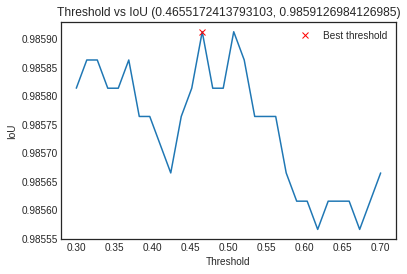

In [32]:
thresholds = np.linspace(0.3,0.7,30)
ious = []
for threshold in tqdm_notebook(thresholds):
    threshold_iou = []
    for image, mask in valid_loader:
        image = image.to(device)
        y_pred = model(image)
        iou = get_iou_vector(y_pred.cpu().detach().numpy() > threshold, mask.numpy())
        threshold_iou.append(iou)
    ious.append(np.mean(threshold_iou))

# instead of using default 0 as threshold, use validation data to find the best threshold.
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()


# Test Prediction:

In [16]:
test_predictions = []
test_predictions_reflect = []

for image in tqdm_notebook(test_loader):
    image_flipped = image[0].cpu().detach().numpy()
    image_flipped = np.flip(image_flipped, 3).copy()
    image_flipped = torch.from_numpy(image_flipped)
    image = image[0].type(torch.float).to(device)
    y_pred = model(image).cpu().detach().numpy()
    image_flipped = image_flipped.type(torch.float).to(device)
    y_pred_flipped = model(image_flipped).cpu().detach().numpy()
    test_predictions.append(y_pred)
    test_predictions_reflect.append(y_pred_flipped)

test_predictions_stacked = np.vstack(test_predictions)[:, 0, :, :]
test_predictions_reflect_stacked = np.vstack(test_predictions_reflect)[:, 0, :, ::-1]

test_predictions_stacked = (test_predictions_stacked + test_predictions_reflect_stacked)/2
test_predictions_stacked = test_predictions_stacked[:, y_min_pad:-y_max_pad, x_min_pad:-x_max_pad]
print(test_predictions_stacked.shape)



/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")



(18000, 128, 128)


In [39]:
test_predictions = []
# Original way (no TTA)
for image in tqdm_notebook(test_loader):
    image = image[0].type(torch.float).to(device)
    # model.load_state_dict(torch.load('uresnetv6e2statef1.pt'))
    y_pred1 = model(image).cpu().detach().numpy()
    #model.load_state_dict(torch.load('uresnetv6e0statef2.pt'))
    #y_pred2 = model(image).cpu().detach().numpy()/2
    test_predictions.append(y_pred1)

    
test_predictions_stacked = np.vstack(test_predictions)[:, 0, :, :]
test_predictions_stacked = test_predictions_stacked[:, y_min_pad:-y_max_pad, x_min_pad:-x_max_pad]

print(test_predictions_stacked.shape)


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


(18000, 101, 101)


__Prepare submission:__

In [40]:
def rle_encode(im):
    pixels = im.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


# To perform RLE, predictions must be in binary integer (0/1) format.
binary_prediction = (test_predictions_stacked > 0.465).astype(int)

# RLE encoding.
all_masks = {idx:rle_encode(binary_prediction[i])
                           for i, idx in enumerate(
                               tqdm_notebook(test_ids))}

In [41]:
submission = pd.DataFrame.from_dict(all_masks, orient='index')
submission.index.names = ['id']
submission.columns = ['rle_mask']
submission.to_csv('submission.csv')